## Histopathological Cancer Detection - Week 3 DL Kaggle Project

This project comes form Kaggle with the link below:

https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

The goal is to identify metastatic cancer in the central 32x32 image patch of larger digital pathology scans.

This project will be my first attempt at creating a neural network and applying convolutional filtering to images.

The train data has 220025 96x96 images and the test set has 57458

My Github repository is here: https://github.com/dmcenery/CancerPredictions.git

In [ ]:
# Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# !pip install tensorflow
#!pip install --upgrade numpy

from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/kaggle/test.zip" -d "/home/test_images"
!unzip -q "/content/drive/MyDrive/kaggle/train.zip" -d "/home/train_images"

Mounted at /content/drive


In [ ]:

# for dirname, _, filenames in os.walk('/content'):
#     print(os.path.join(dirname))

BASE_DIR = "/content/drive/MyDrive/kaggle"

TRAIN_DIR = "/home/train_images"
TEST_DIR = "/home/test_images"
LABELS_PATH = os.path.join(BASE_DIR, "train_labels.csv.zip")


In [ ]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df['id'] = labels_df['id'] + ".tif"
labels_df['label'] = labels_df['label'].astype(str)
print("Dataset shape:", labels_df.shape)
print(labels_df.head())

Dataset shape: (220025, 2)
                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


In [ ]:
import os

num_files = len([f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))])

print(f"There are {num_files} files in the folder: {TEST_DIR}")

num_files = len([f for f in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, f))])

print(f"There are {num_files} files in the folder: {TRAIN_DIR}")

There are 57458 files in the folder: /home/test_images
There are 220026 files in the folder: /home/train_images


## Exploratory Data Analysis and preprocessing

We will start by exploring the train set, then some preprocessing and finally creating a test and validation set for further data exploration.

Print an image to ensure that my paths etc are working

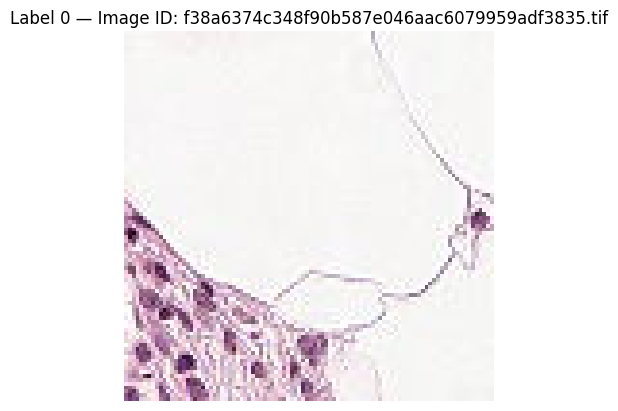

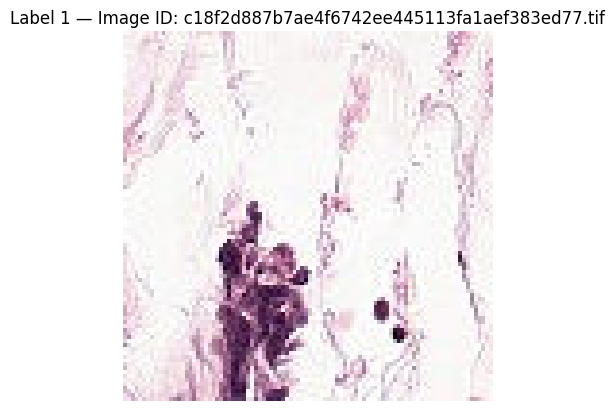

In [ ]:
img0_id = labels_df[labels_df['label'] == '0'].iloc[0]['id']
img1_id = labels_df[labels_df['label'] == '1'].iloc[0]['id']

# Load and display image with label 0
img0 = load_img(os.path.join(TRAIN_DIR, img0_id))
plt.imshow(img0)
plt.title(f"Label 0 — Image ID: {img0_id}")
plt.axis('off')
plt.show()

# Load and display image with label 1
img1 = load_img(os.path.join(TRAIN_DIR, img1_id))
plt.imshow(img1)
plt.title(f"Label 1 — Image ID: {img1_id}")
plt.axis('off')
plt.show()



In [ ]:
from PIL import Image

# class_folders = sorted(os.listdir(TRAIN_DIR))
# first_class_path = os.path.join(TRAIN_DIR, class_folders[0])


# Check image sizes
for i in range(5):
    img_name = labels_df.loc[i, 'id']
    img_path = os.path.join(TRAIN_DIR, img_name)
    with Image.open(img_path) as img:
        print(f"Image {i+1}: {img_name}, size: {img.size}")  # (width, height)

Image 1: f38a6374c348f90b587e046aac6079959adf3835.tif, size: (96, 96)
Image 2: c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif, size: (96, 96)
Image 3: 755db6279dae599ebb4d39a9123cce439965282d.tif, size: (96, 96)
Image 4: bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif, size: (96, 96)
Image 5: 068aba587a4950175d04c680d38943fd488d6a9d.tif, size: (96, 96)


Text(0.5, 1.0, 'Class Distribution')

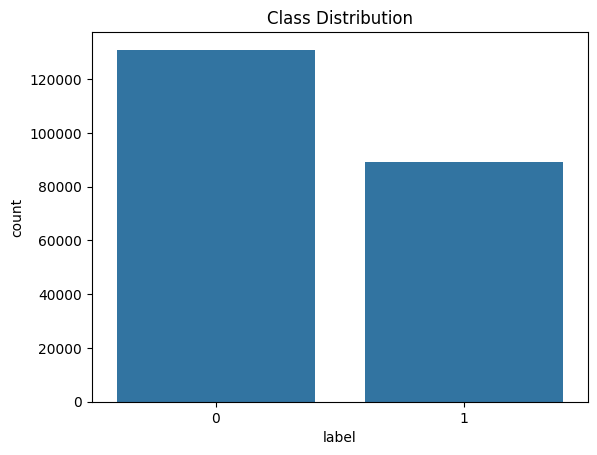

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=labels_df['label'])
plt.title("Class Distribution")


## Model Analysis (building and training)

The first 5 images are 96x96 and I will resize all images to that.

Given that I am using Colab, I will use a 128 batch size.

This is a binary problem - thus a sigmoid function will be my output but ReLu will be used for the hidden layers.

I will start with a dropout of 0.5 and adjust if necessary - lower if my model needs more power and higher if it overfits.

I chose an 80:20 data split and to rescale the colour pixels to between 0 and 1

As we are only interested in the central 32x32 pixels of each image I will preprocess each image further

In [ ]:
def center_crop(img):
    # img is a 3D NumPy array (height, width, channels)
    h, w = img.shape[:2]
    startx = w//2 - (32//2)
    starty = h//2 - (32//2)
    return img[starty:starty+32, startx:startx+32]

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=center_crop
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DIR,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=128,
    seed=50,
    shuffle=True,
    class_mode="binary",
    target_size=(32, 32)
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=TRAIN_DIR,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=128,
    seed=50,
    shuffle=False,
    class_mode="binary",
    target_size=(32, 32)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Given that my input is now 32 x 32, I have kept CNN architecture small

In [ ]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Next it's time to optimize the model

ADAM optimization means that I have an adaptive learning rate which starts at 0.001

I chose 10 epochs with early stopping.



In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=3,
    mode='max',
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

model.evaluate(val_generator)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 275s 195ms/step - accuracy: 0.7962 - auc: 0.8635 - loss: 0.4570 - val_accuracy: 0.7952 - val_auc: 0.9067 - val_loss: 0.4417
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 292s 212ms/step - accuracy: 0.8458 - auc: 0.9175 - loss: 0.3572 - val_accuracy: 0.6673 - val_auc: 0.8399 - val_loss: 1.2893
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 239s 173ms/step - accuracy: 0.8640 - auc: 0.9325 - loss: 0.3227 - val_accuracy: 0.7326 - val_auc: 0.8651 - val_loss: 0.8713
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 222s 161ms/step - accuracy: 0.8785 - auc: 0.9453 - loss: 0.2913 - val_accuracy: 0.7377 - val_auc: 0.8536 - val_loss: 0.7366
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.7938 - auc: 0.9035 - loss: 0.4440


[0.4416981637477875, 0.7951823472976685, 0.9066928029060364]

# Results and Analysis

Initially each epoch appeared to be quicker to run which lowered the cost of additional epochs. However, this was not entirely consistent.

I initially set my early stopping to 3 this yielded an accuracy of 0.8366

I then updated patience to 5 with a set deviation which yielded an accuracy of 0.8583

The additional Epochs overfit the model which resulted in declining validation scores for AUC and accuracy after 5 epochs but it still produced a better accuracy because I had restore best weights set to true.  

Further, I ran the model again with an additional hidden layer which had padding and it increased my accuracy to . I had to include padding as the size of the images was small and another unpadded layer would not have made sense.

My first model took around 20 minutes to run on Colab, with the second model with greater patience taking 30 minutes and the final model with the additional hidden layer with padding took less than 20 minutes.

The additional hidden layer caused the model to optimize more quickly and although each epoch took longer, the model stopped earlier.

The accuracy threshold for a confusion matrix that appeared to be best was around 0.15.




344/344 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step


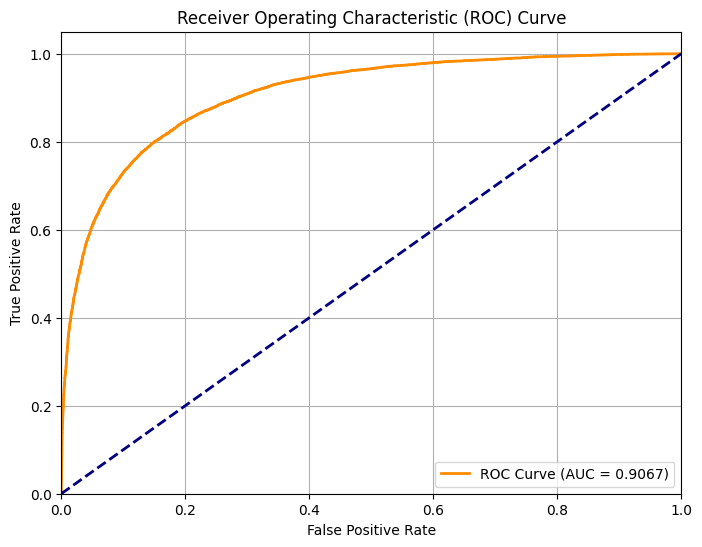

In [ ]:

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)


fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



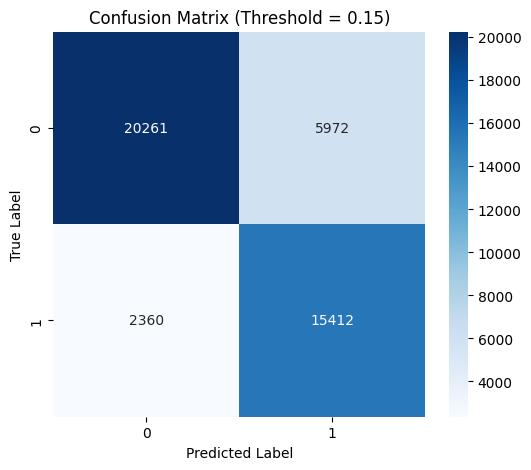

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     26233
           1       0.72      0.87      0.79     17772

    accuracy                           0.81     44005
   macro avg       0.81      0.82      0.81     44005
weighted avg       0.83      0.81      0.81     44005



In [ ]:
threshold = 0.15
y_pred_label = (y_pred_probs >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred_label)
labels = val_generator.class_indices
label_names = list(labels.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred_label, target_names=label_names))

In [ ]:
test_image_files = os.listdir(TEST_DIR)
test_df = pd.DataFrame({'id': test_image_files})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Use the test_df here
    directory=TEST_DIR,
    x_col="id",
    y_col=None,  # No labels for the test set
    batch_size=128,
    seed=50,
    shuffle=False,
    class_mode=None,  # Set class_mode to None for prediction
    target_size=(32, 32)
)

preds = model.predict(test_generator, verbose=1)

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step


In [ ]:
test_filenames = test_generator.filenames


test_ids = [fname.replace(".tif", "") for fname in test_filenames]

# Create the submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,
    "label": preds.flatten()  # Flatten the predictions if they are in a different shape
})

print(submission.head())

# Save the submission file as a CSV
submission.to_csv("/home/submission2.csv", index=False)

print("Submission file created successfully!")

                                         id     label
0  2c2d2b755e3b047de9511c3ca9fe8887b904023c  0.133960
1  2bd7f8d28dc162f7d8f92d846ba84a7e8d75202e  0.606256
2  d727eff8c1b22226bed180d5d91006425353172b  0.519320
3  0cb849cecee6f538ec498a065302b333045db7da  0.045744
4  a94c38f417199af865e409c1c9198d553ad55770  0.041347
Submission file created successfully!


In [ ]:
!git remote add origin https://github.com/dmcenery/CancerPredictions.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
